<a href="https://colab.research.google.com/github/Mayank58786/Machine-Learning/blob/master/Copy_of_Denoising_autoencoders_Mayank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libaries

In [ ]:
import shutil
import statistics as st
 
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Activation, Input, Reshape 
import tensorflow.keras.datasets as datasets
from tensorflow.keras.models import Model

# Loading the Dataset

In [ ]:
(x_train, _), (x_test, _) = datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)

(60000, 28, 28)


In [ ]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Visualizing some images from the dataset

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
 
for i in range(n):
    # display original
 
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
plt.show()

# Defining parameters such as Encoding length

In [ ]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 32
 
layer_filters = [32, 64]

# The Encoder

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
 
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
 
shape = x.shape
x = Flatten()(x)
 
latent = Dense(latent_dim, name='latent_vector')(x)
 
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                100384    
Total params: 119,200
Trainable params: 119,200
Non-trainable params: 0
_________________________________________________________________


# The Decoder

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              103488    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

# Defining the end to end autoencoder

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 32)                119200    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         159169    
Total params: 278,369
Trainable params: 278,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(loss='bce', optimizer='adam')

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Training the autoencoder

In [ ]:
autoencoder.fit(x_train, x_train, epochs=30, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/30
469/469 [==============================] - 4s 9ms/step - loss: 0.1633 - val_loss: 0.0865
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0819 - val_loss: 0.0779
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0773 - val_loss: 0.0756
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0753 - val_loss: 0.0743
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0741 - val_loss: 0.0734
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0733 - val_loss: 0.0727
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0727 - val_loss: 0.0721
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0722 - val_loss: 0.0717
Epoch 9/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0718 - val_loss: 0.0716
Epoch 10/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0715 - val_loss: 0.0712

#Looking at the performance
The First Row consists of input images and the seond row consists of decoded images . 

Ideally they should be the same

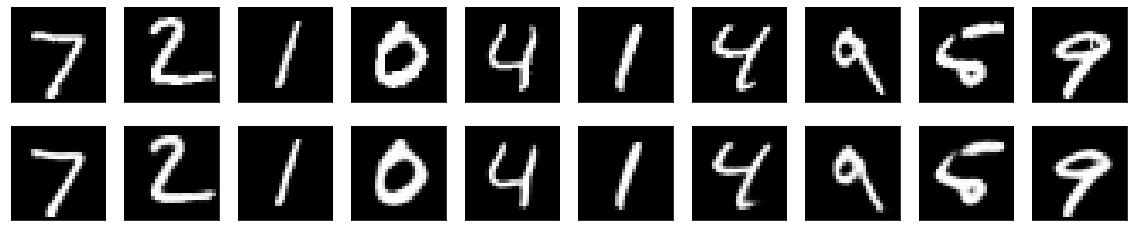

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Lets try to make the model resistant to noise by adding AWGN ( Addititive white Gaussian Noise ) to the inputs

In [ ]:
(x_train, _), (x_test, _) = datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# The noisy images
Clearly these are fairly noisy and it is very difficult to identify the images

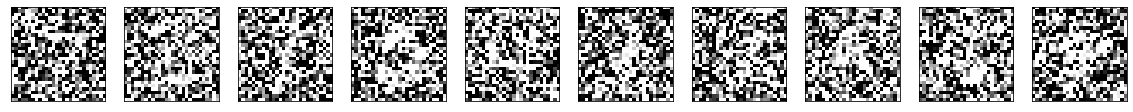

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Defining the same autoencoder structure to be trained to filter out such noise

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = x.shape
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                100384    
Total params: 119,200
Trainable params: 119,200
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output 

In [ ]:
# let's train for 100 epochs
autoencoder.compile(optimizer='adam', loss='bce')

autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/100
938/938 [==============================] - 5s 6ms/step - loss: 0.2235 - val_loss: 0.1721
Epoch 2/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1646 - val_loss: 0.1578
Epoch 3/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1567 - val_loss: 0.1545
Epoch 4/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1532 - val_loss: 0.1534
Epoch 5/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1509 - val_loss: 0.1521
Epoch 6/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1491 - val_loss: 0.1521
Epoch 7/100
938/938 [==============================] - 5s 5ms/step - loss: 0.1475 - val_loss: 0.1519
Epoch 8/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1463 - val_loss: 0.1522
Epoch 9/100
938/938 [==============================] - 5s 5ms/step - loss: 0.1453 - val_loss: 0.1524
Epoch 10/100
938/938 [==============================] - 5s 5ms/step - loss: 0.1442 - val_lo

#Lets look at a few denoised outputs

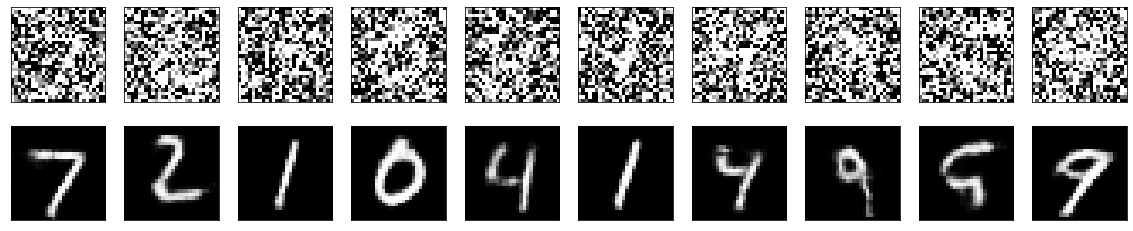

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()